# The material presented in this jupyter notebook is part of the "ECE 685D: Introduction to Deep Learning" course offered at Duke University.

## Restricted Boltzmann Machine (RBM)

<img src="RBM.jpg" width=340 height=340 />

RBM is an undirected graphical model for unsupervised learning. In this session, we will consider stochastic binary visible variables: $x\in\{0,1\}^D$ and stochastic binary hidden variables: $h \in \{0,1\}^H$ to model MNIST images. This will involve training a Bernoulli-Bernoulli RBM for generating images.

### Prerequisites

Recall:

$$P(x, h) = \frac{exp(-E(x, h))}{Z}$$

where $E(x,h)$ is the energy associated with the joint configuration of (x,h). In the Bernoulli-Bernoulli RBM, $E(x, h) := -h^TWx - c^Tx - b^Th$.

Using the above, we can determine the following:

* Marginal of x: $P(x) = \frac{exp(c^Tx + \sum_{j=1}^H softplus{(b_j + W_{j.}x)} )}{Z} = \frac{exp(-F(x))}{Z}$, where $F(x)$ is called the "free energy".
* Conditionals: $p(x|h)$ and $p(h|x)$.

Note: $Z = \sum_{x,h} exp(-E(x,h)) = \sum_x exp(-F(x)) $

Objective: Minimize the Negative log-likelihood $-ln(P(x))$ of training samples:

$$
\begin{align}
-lnP(x) &= F(x) + ln(Z) \\ \\
% -\frac{\partial lnP(x)}{\partial \theta} &= \frac{\partial F(x)}{\partial \theta} + \frac{\partial lnZ}{\partial \theta} \\
-\frac{\partial lnP(x)}{\partial \theta} &= \frac{\partial F(x)}{\partial \theta} - \sum_{\tilde{x}} p(\tilde{x}) \frac{\partial F(\tilde{x})}{\partial \theta} 
\end{align}
$$

where $\tilde{x}$ denotes the negative sample. To sample $\tilde{x}$, we use MCMC.

**Contrastive Divergence (CD-k)**

Contrastive Divergence uses two tricks to speed up the sampling process:

* We initialize the Markov chain with a training example.
* CD does not wait for the chain to converge. Samples are obtained after only k-steps of Gibbs sampling.

* ### Train Bernoulli-Bernoulli RBM

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

## Setup dataloader

In [8]:
batch_size = 128
train_set, test_set, train_loader, test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader['mnist'] = torch.utils.data.DataLoader(train_set['mnist'], batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['mnist'] = torch.utils.data.DataLoader(test_set['mnist'], batch_size=batch_size, shuffle=False, num_workers=0)

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [9]:
class RBM(nn.Module):
    """Restricted Boltzmann Machine for generating MNIST images."""
    
    def __init__(self, D: int, F: int, k: int):
        """Creates an instance RBM module.
            
            Args:
                D: Size of the input data.
                F: Size of the hidden variable.
                k: Number of MCMC iterations for negative sampling.
                
            The function initializes the weight (W) and biases (c & b).
        """
        
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(F, D)* 1e-2) # Initialized from Normal(mean=0.0, variance=1e-4)
        self.c = nn.Parameter(torch.zeros(D)) # Initialized as 0.0
        self.b = nn.Parameter(torch.zeros(F)) # Initilaized as 0.0
        self.k = k
    
    def sample(self, p):
        """Sample from a bernoulli distribution defined by a given parameter.
        
           Args:
                p: Parameter of the bernoulli distribution.
           
           Returns:
               bern_sample: Sample from Bernoulli(p)
        """
        
        bern_sample = p.bernoulli()
        return bern_sample
    
    def P_h_x(self, x):
        """Returns the conditional P(h|x). (Slide 9, Lecture 14)
        
        Args:
            x: The parameter of the conditional h|x.
        
        Returns:
            ph_x: probability of hidden vector being element-wise 1.
        """

        ph_x = torch.sigmoid(F.linear(x, self.W, self.b)) # n_batch x F
        return ph_x
    
    def P_x_h(self, h):
        """Returns the conditional P(x|h). (Slide 9, Lecture 14)
        
        Args:
            h: The parameter of the conditional x|h.
        
        Returns:
            px_h: probability of visible vector being element-wise 1.
        """
        
        px_h = torch.sigmoid(F.linear(h, self.W.t(), self.c)) # n_batch x D
        return px_h

    def free_energy(self, x):
        """Returns the Average F(x) free energy. (Slide 11, Lecture 14)."""
        
        vbias_term = x.mv(self.c) # n_batch x 1
        wv_b = F.linear(x, self.W, self.b) # n_batch x F
        hidden_term = F.softplus(wv_b).sum(dim=1) # n_batch x 1
        return (-hidden_term - vbias_term).mean() # 1 x 1 
    
    def forward(self, x):
        """Generates x_negative using MCMC Gibbs sampling starting from x."""
        
        x_negative = x
        for _ in range(self.k):
            
            ## Step 1: Sample h from previous iteration.
            # Get the conditional prob h|x
            phx_k = self.P_h_x(x_negative) 
            # Sample from h|x
            h_negative = self.sample(phx_k)
            
            ## Step 2: Sample x using h from step 1.
            # Get the conditional proba x|h
            pxh_k = self.P_x_h(h_negative)
            # Sample from x|h
            x_negative = self.sample(pxh_k)

        return x_negative, pxh_k

## Define train and test functions

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    
    train_loss = 0
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # torchvision provides us with normalized data, s.t. input is in [0,1]
        data = data.view(data.size(0),-1) # flatten the array: Converts n_batchx1x28x28 to n_batchx784
        data = data.bernoulli() 
        data = data.to(device)
        
        optimizer.zero_grad()
        
        x_tilde, _ = model(data)
        x_tilde = x_tilde.detach()
        
        loss = model.free_energy(data) - model.free_energy(x_tilde)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if (batch_idx+1) % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))

def test(model, device, test_loader, epoch):
    
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1)
            data = data.bernoulli()
            data = data.to(device)
            xh_k,_ = model(data)
            loss = model.free_energy(data) - model.free_energy(xh_k)
            test_loss += loss.item() # sum up batch loss
    
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(epoch, test_loss))

## __Define make_optimizer and make_schedule__

In [11]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs.get('momentum', 0.), 
                              weight_decay=kwargs.get('weight_decay', 0.))
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

In [6]:
# General variables

seed = 1
data_name = 'mnist'
optimizer_name = 'Adam'
scheduler_name = 'MultiStepLR'
num_epochs = 10
lr = 0.001


In [13]:
device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

rbm = RBM(D=28*28, F=400, k=5).to(device)
optimizer = make_optimizer(optimizer_name, rbm, lr=lr)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)

for epoch in range(1, num_epochs + 1):
    
    train(rbm, device, train_loader[data_name], optimizer, epoch)
    test(rbm, device, test_loader[data_name], epoch)
    scheduler.step()
    
    print('Optimizer Learning rate: {0:.4f}\n'.format(optimizer.param_groups[0]['lr']))

Train(1)[50%]: Loss: -34.6239
Train(1)[100%]: Loss: -24.9552
Test(1): Loss: -16.4574
Optimizer Learning rate: 0.0010

Train(2)[50%]: Loss: -14.6208
Train(2)[100%]: Loss: -14.3996
Test(2): Loss: -14.1250
Optimizer Learning rate: 0.0010

Train(3)[50%]: Loss: -13.4825
Train(3)[100%]: Loss: -13.2518
Test(3): Loss: -14.3464
Optimizer Learning rate: 0.0010

Train(4)[50%]: Loss: -12.5919
Train(4)[100%]: Loss: -12.2806
Test(4): Loss: -12.1953
Optimizer Learning rate: 0.0010

Train(5)[50%]: Loss: -11.4275
Train(5)[100%]: Loss: -11.0797
Test(5): Loss: -11.5095
Optimizer Learning rate: 0.0001

Train(6)[50%]: Loss: -10.9281
Train(6)[100%]: Loss: -10.8532
Test(6): Loss: -12.2198
Optimizer Learning rate: 0.0001

Train(7)[50%]: Loss: -10.9561
Train(7)[100%]: Loss: -10.9876
Test(7): Loss: -12.0656
Optimizer Learning rate: 0.0001

Train(8)[50%]: Loss: -10.9399
Train(8)[100%]: Loss: -10.8125
Test(8): Loss: -11.8894
Optimizer Learning rate: 0.0001

Train(9)[50%]: Loss: -10.6230
Train(9)[100%]: Loss: -10.

## Plot

In [14]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    fig.show()

## Plot original images and reconstructed images using the test dataset

In [15]:
data,_ = next(iter(test_loader[data_name]))
data = data[:32]
data_size = data.size()
data = data.view(data.size(0),-1)
bdata = data.bernoulli().to(device)
vh_k, pvh_k = rbm(bdata)
vh_k, pvh_k = vh_k.detach(), pvh_k.detach()

/var/folders/w5/_y5qsxd54h7g1_bgp2wv659h0000gn/T/ipykernel_89714/2568326077.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


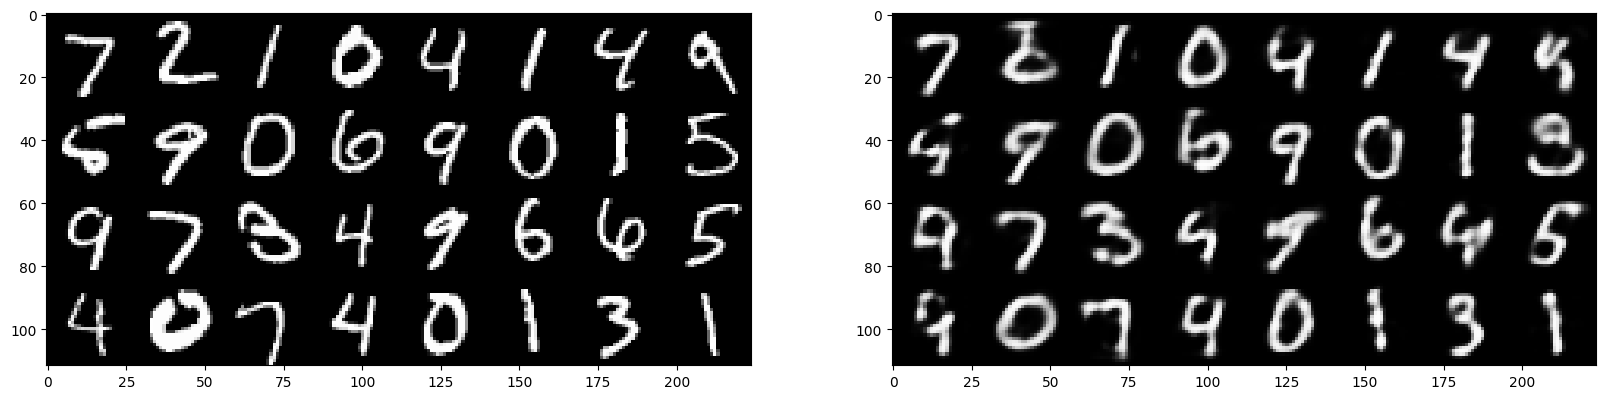

In [16]:
show(make_grid(data.reshape(data_size), padding=0), make_grid(pvh_k.reshape(data_size), padding=0))